[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-01-22 08:29:38.030194: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-22 08:29:38.030227: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-22 08:29:38.030234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-22 08:29:38.030284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-22 08:29:38.030302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-22 08:29:38.599793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/marcusdaghlian/miniforge

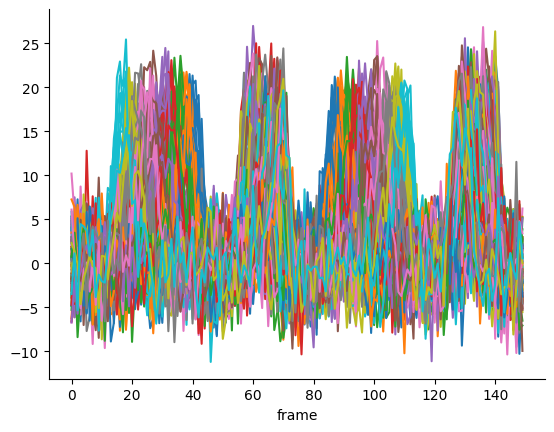

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import datetime
print(tf.config.list_physical_devices('GPU'))
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]
x, y = np.meshgrid(np.linspace(-.75, .75, 10), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 10))
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
data = model.simulate(noise=3)
data.plot(legend=False)
sns.despine()
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
model2 = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                      hrf_model=SPMHRFModel(tr=1.7))

bounds = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0, 100], 
}
bfitter = BPRF(model=model2, data=data, )
bfitter.add_priors_from_bounds(bounds)
n_vx = 9
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),

})

In [4]:
bfitter.model.parameter_labels

['x', 'y', 'sd', 'baseline', 'amplitude']

In [5]:

# Test timing 
print('Timing')

start = datetime.datetime.now()
a = bfitter.fit(
    idx=[0], 
    init_pars=init_pars,
    num_results=100,     
    
    #ols_pars,
    # fixed_pars={'baseline' : 0.0}
)
print(datetime.datetime.now() - start)


Timing
x
y
sd
baseline
amplitude
0:00:02.985414


In [2]:
cfitter = ParameterFitter(model, data, paradigm)
timenow = datetime.datetime.now()
grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 40), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 40),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)
print(datetime.datetime.now() - timenow)

Working with chunk size of 44444
Using correlation cost!


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.63409233e+00 4.35109186e+00 2.44210863e+00 3.00032592e+00
 2.57264352e+00 3.75103855e+00 6.91709375e+00 4.73838043e+00
 2.75978136e+00 1.64326501e+00 6.13450193e+00 4.17504549e+00
 4.98824418e-01 1.21419334e+00 1.84963775e+00 1.95331216e-01
 8.77401084e-02 2.21557903e+00 3.58152604e+00 1.50414753e+00
 4.42389631e+00 5.35525262e-01 1.00000000e-04 4.67973083e-01
 1.00000000e-04 9.34552327e-02 1.00000000e-04 1.00000000e-04
 1.00000000e-04 1.00000000e-04 2.85681939e+00 1.00000000e-04
 1.00000000e-04 1.00000000e-04 1.00000000e-04 1.00000000e-04
 1.00000000e-04 1.00000000e-04 1.00000000e-04 1.00000000e-04
 1.54208672e+00 1.00000000e-04 1.00000000e-04 1.00000000e-04
 1.00000000e-04 1.00000000e-04 1.00000000e-04 1.00000000e-04
 1.00000000e-04 1.

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: 0.09248/Best R2: 0.09296: 100%|██████████| 1000/1000 [00:42<00:00, 23.71it/s]


0:00:47.391952


In [6]:
bfitter.mcmc_sampler[0]

,x,y,sd,baseline,amplitude
0,-0.731176,-0.400295,0.157620,-0.118652,1.019908
1,-0.744966,-0.421570,0.167893,-0.132063,1.046059
2,-0.724072,-0.394824,0.137986,-0.139455,1.062118
3,-0.724072,-0.394824,0.137986,-0.139455,1.062118
4,-0.737003,-0.406552,0.153002,-0.109556,1.047401
...,...,...,...,...,...
95,-0.738432,-0.394319,0.158185,-0.148128,1.014026
96,-0.725235,-0.407087,0.150843,-0.149346,1.057438
97,-0.725235,-0.407087,0.150843,-0.149346,1.057438
98,-0.736136,-0.400241,0.154469,-0.180000,1.040668


/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

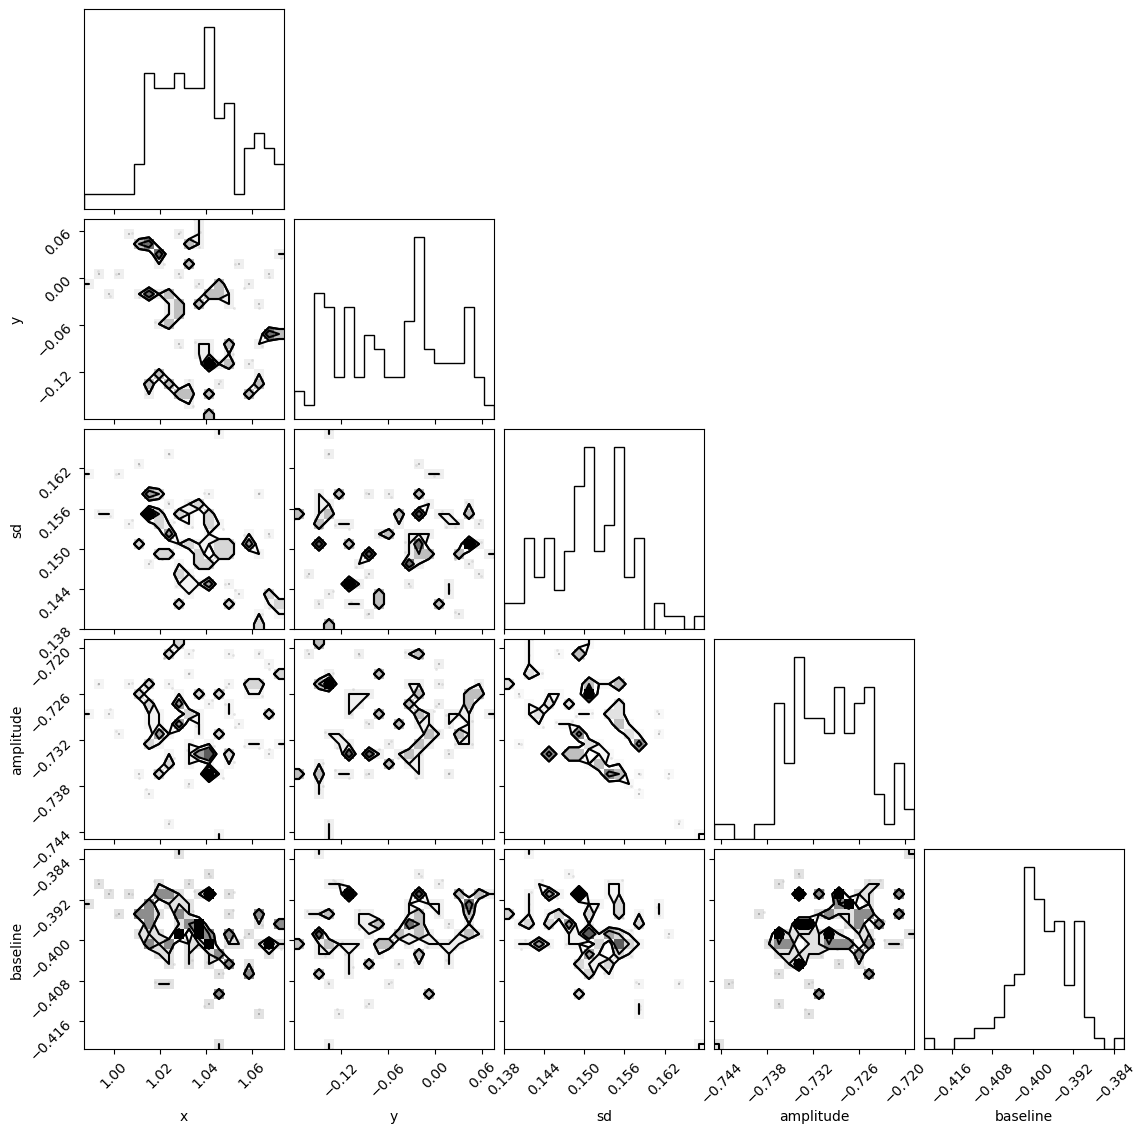

In [7]:
import corner
labels = ['x', 'y', 'sd', 'amplitude', 'baseline']
truths = [parameters.iloc[0,:][l] for l in labels]
_ = corner.corner(
    bfitter.mcmc_sampler[0].iloc[0:,:],
    labels=labels,
    truths=parameters.iloc[0,:]

    )

In [ ]:
truths

(-0.18, 1.0)

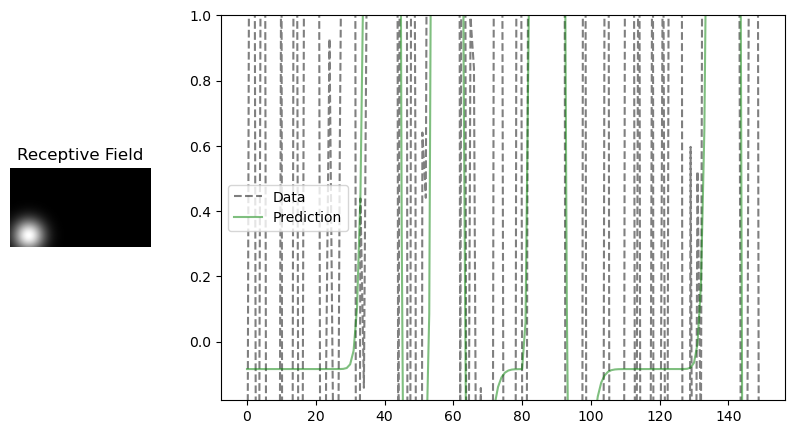

In [15]:
from braincoder.utils.visualize import quick_plot
quick_plot(
    bfitter.model, 
    parameters=bfitter.mcmc_sampler[0].iloc[-1,:],
    data=data.iloc[:,0],
)
bfitter.mcmc_sampler[0].iloc[-1,:]
plt.gca().set_ylim(-.18, 1)
# quick_plot(
#     model2, 
#     parameters=parameters.iloc[1,:],
#     data=data.iloc[:,1],
# )

In [ ]:
bfitter.mcmc_sampler[0].iloc[50,:]

In [ ]:
parameters